# Imports

In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.datasets.mnist import load_data as load_digits
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import load_model

2023-05-13 21:04:07.637470: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Introduction

The MNIST (Modified National Institute of Standards and Technology) dataset is one of the most popular and widely used datasets in the field of machine learning. It is a collection of 70,000 grayscale images of handwritten digits, each of which is 28x28 pixels in size. The images are labeled with the corresponding digit from 0 to 9, making it a classification problem.

The MNIST dataset was first released in 1998 and has since become a benchmark dataset for testing machine learning algorithms, particularly in the field of computer vision. The dataset is often used to evaluate the performance of image classification models, and it is considered a standard dataset for testing and comparing different machine learning techniques.

The dataset is split into two parts: a training set and a test set. The training set contains 60,000 images, while the test set contains 10,000 images. The images in the dataset have been preprocessed to normalize the pixel values to a range between 0 and 1, making it easier to work with them using machine learning algorithms.

The MNIST dataset has several advantages that make it an ideal dataset for testing machine learning algorithms. First, it is a relatively simple dataset, with only 10 classes (digits 0 to 9). This makes it easier to train models and compare their performance. Second, the images are of a fixed size and are well-aligned, making it easy to preprocess them for machine learning tasks. Finally, the dataset is large enough to provide a good amount of training data for machine learning models, while also being small enough to allow for quick experimentation.

The MNIST dataset has been used extensively in the development of machine learning algorithms, particularly in the field of deep learning. In 2011, a team led by Geoffrey Hinton achieved a breakthrough in image recognition using deep learning techniques, using a deep convolutional neural network to achieve an error rate of just 0.35%. This was a significant improvement over previous state-of-the-art algorithms, which achieved error rates of around 1-2%.

The MNIST dataset is included in several popular machine learning libraries, including scikit-learn, TensorFlow, and PyTorch. In scikit-learn, the MNIST dataset can be loaded using the fetch_openml function, which downloads the dataset from the OpenML repository and returns it as a scikit-learn Bunch object. This makes it easy to load the dataset and start working with it in Python.

Different from the dataset mentioned above, the [dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) in `scikit-learn` has a lower scale. Each image is 8x8 in size and the number of samples in total is 1797. 

In conclusion, the MNIST dataset is a widely used benchmark dataset in the field of machine learning, particularly in the area of computer vision. Its simplicity, fixed image size, and large size make it an ideal dataset for testing and comparing different machine learning algorithms.

# Problem Definition

In this demo, we are going to apply a Convolutional Neural Network (CNN) to the image data, aiming at classifying images into digits from `0` to `9` inclusive. 

CNNs are a powerful class of deep learning algorithms that are widely used for image classification tasks, such as recognizing handwritten digits in the MNIST dataset. CNNs are designed to automatically learn and extract meaningful features from input images, making them highly effective for tasks such as object recognition, detection, and segmentation.

CNNs consist of multiple layers, each of which performs a specific function in the network. The first layer of a CNN is typically a convolutional layer, which applies a set of learnable filters to the input image to extract local features such as edges and corners. The output of the convolutional layer is then passed through a non-linear activation function, such as ReLU, to introduce non-linearity into the network.

Subsequent layers in the network typically alternate between pooling layers, which reduce the spatial resolution of the input features, and additional convolutional layers, which extract increasingly abstract and complex features from the input. Finally, the output of the convolutional layers is flattened into a vector and passed through one or more fully connected layers, which use this vector to classify the input image into one of the possible output categories.

The architecture of a CNN can be customized depending on the specific task at hand. For example, the number and size of the filters in the convolutional layers can be adjusted to extract different types of features, while the number and size of the fully connected layers can be adjusted to accommodate different output classes. 

# Load the dataset

In [2]:
(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = load_digits()

In [3]:
train_size = X_train_raw.shape[0]
test_size = X_test_raw.shape[0]

# Visualize a random image

In [4]:
def visualize_one_image(from_='train', idx=None, show_idx=False, return_idx=False):
    if from_ not in ['train', 'test']:
        raise KeyError('the variable from_ can either be \'train\' or \'test\'!')
    plt.gray()
    if from_ == 'train':
        if idx is None:
            idx = random.randint(0, train_size-1)
        assert 0 <= idx <= train_size - 1
        img_arr = np.reshape(X_train_raw[idx], (28, 28))
    elif from_ == 'test':
        if idx is None:
            idx = random.randint(0, test_size-1)
        assert 0 <= idx <= test_size - 1
        img_arr = np.reshape(X_test_raw[idx], (28, 28))
    plt.matshow(img_arr)
    if show_idx:
        plt.title(f'Visualizing example {idx} from {from_} set')
    plt.show()
    if return_idx:
        return idx

<Figure size 640x480 with 0 Axes>

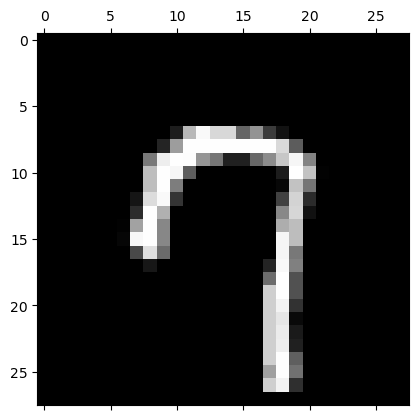

In [5]:
visualize_one_image()

# Preprocessing

In [6]:
def reshape_data(img_data):
    n, w, h = img_data.shape[0], img_data.shape[1], img_data.shape[2]
    reshaped_data = img_data.reshape((n, w, h, 1))
    return reshaped_data

In [7]:
def scale_images(img_data):
    return img_data.astype('float32') / 255.0

In [8]:
def preprocess_images(X_train, X_test):
    X_train, X_test = reshape_data(X_train), reshape_data(X_test)
    X_train, X_test = scale_images(X_train), scale_images(X_test)
    return X_train, X_test

In [9]:
X_train, X_test = preprocess_images(X_train_raw, X_test_raw)

In [10]:
def preprocess_target(y_train, y_test):
    y_train, y_test = np.reshape(y_train, (-1, 1)), np.reshape(y_test, (-1, 1))
    ohe = OneHotEncoder()
    y_train = ohe.fit_transform(y_train)
    y_test = ohe.transform(y_test)
    return y_train.toarray(), y_test.toarray()

In [11]:
y_train, y_test = preprocess_target(y_train_raw, y_test_raw)

# Build a Convolutional Neural Network (CNN)

In [12]:
# initialize a Sequential object for the model
model = Sequential()
# layer 1: convolutional layer with 32 output channels, kernel size 3x3
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
# max pooling
model.add(MaxPooling2D(2, 2))
# layer 2: convolutional layer with 16 output channels, kernel size 3x3
model.add(Conv2D(16, (3, 3), activation='relu'))
# flatten everything into a column vector
model.add(Flatten())
# layer 3: fully connected layer
model.add(Dense(10, activation='softmax'))

2023-05-13 21:04:15.394225: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        4624      
                                                                 
 flatten (Flatten)           (None, 1936)              0         
                                                                 
 dense (Dense)               (None, 10)                19370     
                                                                 
Total params: 24,314
Trainable params: 24,314
Non-trainable params: 0
____________________________________________________

In [15]:
MODEL_PATH = '../models/demo_6_digits_classifier.h5'

In [16]:
model_exists = os.path.exists(MODEL_PATH)
model_exists

True

In [17]:
if not model_exists:
    model.fit(X_train, y_train, epochs=8, batch_size=128, verbose=1)
    model.save(MODEL_PATH)
else:
    model = load_model(MODEL_PATH)

# Prediction

Let's get an image from the test set: 

<Figure size 640x480 with 0 Axes>

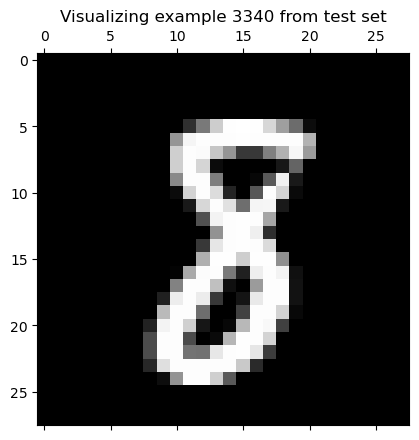

In [18]:
img_idx = visualize_one_image(from_='test', idx=3340, show_idx=True, return_idx=True)

In [19]:
img_idx

3340

In [20]:
def predict_image_class(example):
    n, w, h = example.shape[0], example.shape[1], example.shape[2]
    X_test = [example.reshape(1, n, w, h)]
    y_pred = np.argmax(model.predict(X_test))
    return y_pred

In [21]:
example = X_test[3340]
predicted_class = predict_image_class(example)
print(f'The predicted class for this image is {predicted_class}')

1/1 [==============================] - 0s 134ms/step
The predicted class for this image is 8


# Prediction from unseen images

The images we obtained are from the test data. Let's try to hand-write some digits and test the model. 

In [22]:
IMAGE_1_PATH = '../figs/demo_6_test_digit_6.jpeg'
IMAGE_2_PATH = '../figs/demo_6_test_digit_9.jpeg'

In [23]:
def crop_and_show_image(img_path):
    if os.path.exists(img_path):
        with Image.open(img_path) as image:
            # Crop the image to the appropriate size
            width, height = image.size
            crop_size = min(width, height)
            left = (width - crop_size) // 2
            top = (height - crop_size) // 2
            right = left + crop_size
            bottom = top + crop_size
            image = image.crop((left, top, right, bottom))

            # Resize the image to 28x28 pixels
            image = image.resize((28, 28))

            # Convert the image to grayscale
            image = image.convert('L')

            # Convert the image to a NumPy array
            image_array = np.array(image)

            # Normalize the pixel values to be between 0 and 1
            image_array = image_array / 255.0

            # Reshape the array to have a single channel (since the MNIST dataset has grayscale images)
            image_array = image_array.reshape((28, 28, 1))
            
            # show the image
            plt.matshow(image_array)
            plt.show()
            
        return image_array

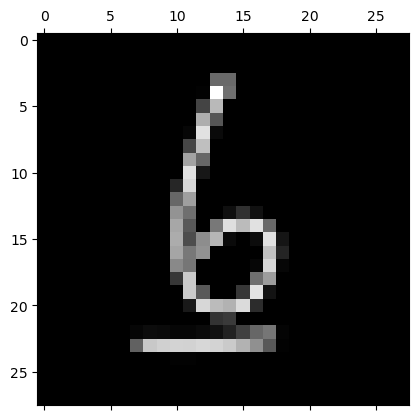

In [24]:
img_1_arr = crop_and_show_image(IMAGE_1_PATH)

In [25]:
predicted_class = predict_image_class(img_1_arr)
print(f'The predicted class for this image is {predicted_class}')

1/1 [==============================] - 0s 32ms/step
The predicted class for this image is 1


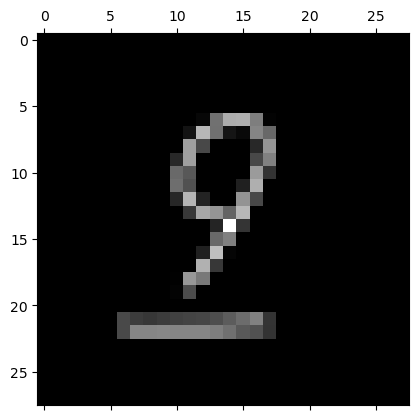

In [26]:
img_2_arr = crop_and_show_image(IMAGE_2_PATH)

In [27]:
predicted_class = predict_image_class(img_2_arr)
print(f'The predicted class for this image is {predicted_class}')

1/1 [==============================] - 0s 29ms/step
The predicted class for this image is 1


Something interesting happens! To avoid confusion, sometimes we write a bar under the digit `6` and `9`. However, since our model has never exposed to such examples, it interestingly predicts `1`! (probably due to the bar written)

Let's try a more realistic example, using the digit `7`. 

In [28]:
IMAGE_3_PATH = '../figs/demo_6_test_digit_7.jpeg'

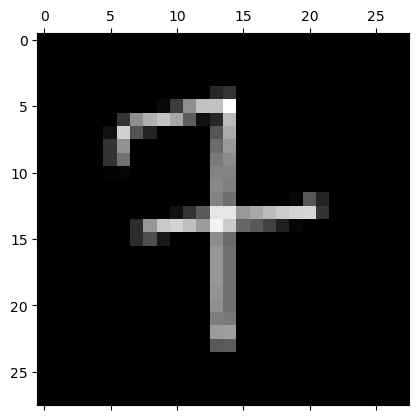

In [29]:
img_3_arr = crop_and_show_image(IMAGE_3_PATH)

In [30]:
predicted_class = predict_image_class(img_3_arr)
print(f'The predicted class for this image is {predicted_class}')

1/1 [==============================] - 0s 31ms/step
The predicted class for this image is 8


Probably the model hasn't encountered this writing style of the digit `7`...

Let's try one more example: 

In [31]:
IMAGE_4_PATH = '../figs/demo_6_test_digit_5.jpeg'

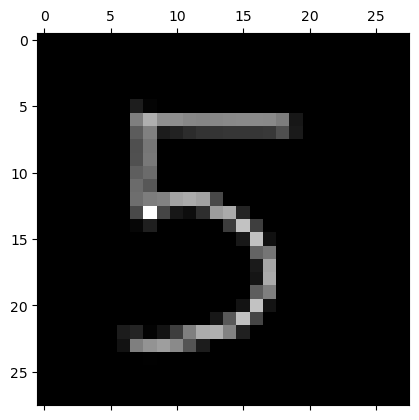

In [32]:
img_4_arr = crop_and_show_image(IMAGE_4_PATH)

In [33]:
predicted_class = predict_image_class(img_4_arr)
print(f'The predicted class for this image is {predicted_class}')

1/1 [==============================] - 0s 32ms/step
The predicted class for this image is 5


Seems it is working! Nice job! 